### Enrichment simulation notebook 
##### step 1: import all required packages

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")


RAW = Path("../data/raw/creditcard.csv")
assert RAW.exists(), "Dataset not found. Place creditcard.csv in data/raw/"

df = pd.read_csv(RAW)
print(f"Loaded {df.shape[0]:,} rows × {df.shape[1]} columns")

Loaded 284,807 rows × 31 columns


##### step 2: in this step i will provide all parameter which is need to enrichment 

In [6]:
from datetime import datetime

np.random.seed(42)

DEVICE_OSES = ["Android", "iOS", "Windows", "MacOS"]
BROWSERS = ["Chrome", "Safari", "Edge", "Firefox"]
COUNTRIES = ["DE", "US", "GB", "FR", "NL", "ES", "IT", "IN", "BR", "CA"]

def deterministic_device_id(series):
    return ("dev_" + (series.astype(int) % 10000).astype(str))


In [7]:
df["device_id"] = deterministic_device_id(df["Time"])
df["device_os"] = np.random.choice(DEVICE_OSES, len(df))
df["browser"] = np.random.choice(BROWSERS, len(df))

# Fraud-based new device probability
df["is_new_device"] = np.where(df["Class"] == 1,
                               np.random.rand(len(df)) < 0.25,
                               np.random.rand(len(df)) < 0.05)

# Network features
df["ip_country"] = np.random.choice(COUNTRIES, len(df))
df["is_proxy_vpn"] = np.random.rand(len(df)) < 0.1
df["ip_reputation"] = np.where(df["Class"] == 1,
                               np.random.uniform(0.5, 1.0, len(df)),
                               np.random.uniform(0.0, 0.7, len(df)))


#### velcoity features

In [8]:
df = df.sort_values("Time")
df["txn_count_5m"] = 1
df["txn_count_30m"] = 1
df["txn_count_60m"] = 1

# approximate per device
for dev, grp in df.groupby("device_id"):
    idx = grp.index
    t = grp["Time"].to_numpy()
    df.loc[idx, "txn_count_5m"] = np.searchsorted(t, t) - np.searchsorted(t, t - 300)
    df.loc[idx, "txn_count_30m"] = np.searchsorted(t, t) - np.searchsorted(t, t - 1800)
    df.loc[idx, "txn_count_60m"] = np.searchsorted(t, t) - np.searchsorted(t, t - 3600)

df["avg_amount_7d"] = df.groupby("device_id")["Amount"].transform(lambda x: x.rolling(50, 1).mean())


In [9]:
df["account_age_days"] = np.where(df["Class"] == 1,
                                  np.random.randint(0, 300, len(df)),
                                  np.random.randint(0, 1000, len(df)))
df["token_age_days"] = np.random.randint(0, 365, len(df))
df["avg_spend_user_30d"] = np.exp(np.random.normal(3, 1, len(df))).round(2)

df["billing_country"] = np.random.choice(COUNTRIES, len(df))
df["shipping_country"] = np.random.choice(COUNTRIES, len(df))
df["country_mismatch"] = df["billing_country"] != df["shipping_country"]


In [10]:
# Timestamp conversion
anchor = pd.Timestamp("2013-09-01 00:00:00")
ts = anchor + pd.to_timedelta(df["Time"], unit="s")
df["hour"] = ts.dt.hour
df["weekday"] = ts.dt.weekday

df["night_txn"] = df["hour"].isin([0,1,2,3,4,5,23])
df["weekend_txn"] = df["weekday"].isin([5,6])

df["amount_zscore"] = df.groupby("device_id")["Amount"].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-9)
)


In [11]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
df.head(5)


Rows: 284807
Columns: 53


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,token_age_days,avg_spend_user_30d,billing_country,shipping_country,country_mismatch,hour,weekday,night_txn,weekend_txn,amount_zscore
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,98,120.37,BR,ES,True,0,6,True,True,0.865892
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,115,12.46,ES,IN,True,0,6,True,True,-0.674769
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,219,14.62,BR,DE,True,0,6,True,True,1.979324
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,106,39.11,FR,IN,True,0,6,True,True,0.212771
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,322,63.73,IN,DE,True,0,6,True,True,-0.208059


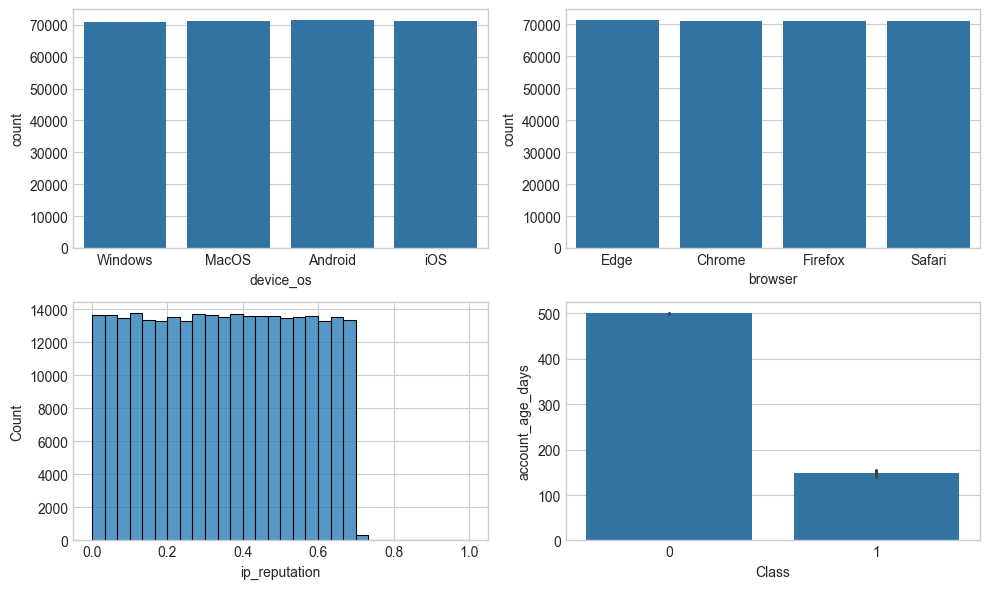

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10,6))
sns.countplot(x="device_os", data=df, ax=axes[0,0])
sns.countplot(x="browser", data=df, ax=axes[0,1])
sns.histplot(df["ip_reputation"], bins=30, ax=axes[1,0])
sns.barplot(x="Class", y="account_age_days", data=df, ax=axes[1,1])
plt.tight_layout()
plt.show()


In [20]:

out_path = Path("../data/processed/enriched_sample.csv")

out_path.parent.mkdir(parents=True, exist_ok=True)

df.to_csv(out_path, index=False)

print(f"✅ Enriched dataset saved successfully to {out_path}")

✅ Enriched dataset saved successfully to ../data/processed/enriched_sample.csv


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load the enriched dataset
df_enriched = pd.read_csv("../data/processed/enriched_sample.csv")

print(f"✅ Loaded enriched dataset: {df_enriched.shape[0]:,} rows × {df_enriched.shape[1]} columns\n")

# Basic integrity checks
print("🧩 Basic checks:")
print(f" - Missing values: {df_enriched.isna().sum().sum()}")
print(f" - Unique device IDs: {df_enriched['device_id'].nunique()}")
print(f" - Fraud ratio: {df_enriched['Class'].mean():.4f}")

# Key feature distributions
report_data = {
    "Fraud Count": int(df_enriched['Class'].sum()),
    "Legit Count": int((df_enriched['Class']==0).sum()),
    "New Device %": 100 * df_enriched['is_new_device'].mean(),
    "Proxy/VPN %": 100 * df_enriched['is_proxy_vpn'].mean(),
    "Avg IP Reputation": df_enriched['ip_reputation'].mean(),
    "Avg Account Age (days)": df_enriched['account_age_days'].mean(),
    "Avg Geo Distance (km)": df_enriched.get('geo_distance_km', pd.Series()).mean() if 'geo_distance_km' in df_enriched.columns else np.nan,
}

summary = pd.DataFrame.from_dict(report_data, orient='index', columns=['Value'])
display(summary)


✅ Loaded enriched dataset: 284,807 rows × 53 columns

🧩 Basic checks:
 - Missing values: 0
 - Unique device IDs: 10000
 - Fraud ratio: 0.0017


,Value
Fraud Count,492.000000
Legit Count,284315.000000
New Device %,4.987939
Proxy/VPN %,9.907762
Avg IP Reputation,0.350101
Avg Account Age (days),499.660546
Avg Geo Distance (km),NaN


In [3]:
from datetime import datetime

report_path = Path("../docs/enrichment_report.md")
report_path.parent.mkdir(parents=True, exist_ok=True)

with open(report_path, "w") as f:
    f.write("# Enrichment Report — Synthetic Contextual Features\n\n")
    f.write(f"Generated on: {datetime.now():%Y-%m-%d %H:%M:%S}\n\n")
    f.write("## Dataset Summary\n")
    f.write(f"- Rows: {df_enriched.shape[0]:,}\n")
    f.write(f"- Columns: {df_enriched.shape[1]}\n")
    f.write(f"- Fraud Ratio: {df_enriched['Class'].mean():.4%}\n\n")
    f.write("## Key Enrichment Metrics\n")
    for k, v in report_data.items():
        f.write(f"- **{k}:** {v:.2f}\n")
    f.write("\n## Notes\n")
    f.write("- Deterministic seed used for reproducibility (seed=42)\n")
    f.write("- Device, network, and profile features simulated with realistic skew\n")
    f.write("- Future iterations will replace this synthetic generator with live preauth event data\n")

print(f"✅ Enrichment report generated: {report_path.resolve()}")


✅ Enrichment report generated: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/enrichment_report.md
